In [1]:
import numpy as np
import scipy.sparse
import pywt
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Question 2:

## problem setting:

In [2]:
# global constant setting
m, n = 500, 1000
lamb = 1/np.sqrt(np.max([m,n]))
print('lambda: ' + str(lamb))

lambda: 0.03162277660168379


In [3]:
# generate W, H and L_0
np.random.seed(519)

W = np.random.normal(loc=0, scale=1, size=(m, 10))
H = np.random.normal(loc=0, scale=1, size=(10, n))

L_0 = W@H
print('matrix L_0 is:')
print(L_0)

matrix L_0 is:
[[ 2.48148571  2.78537711  3.14180555 ...  5.49694983 -0.83004372
  -0.87210189]
 [ 4.25343252 -2.09653516  1.77054136 ... -6.88476335 -7.32646988
   0.47151569]
 [ 1.98889846 -1.30682427 -1.6062652  ... -3.2240524   2.86435968
  -1.75542304]
 ...
 [ 0.91818554  1.79303488 -1.67370578 ... -2.77439824 -6.48909716
   1.6580255 ]
 [ 3.09572441  0.97665845  0.69411652 ... -0.47605804  0.32747054
  -2.97296535]
 [ 6.3461416   5.09488644  3.8675893  ...  6.38656176 -3.64678434
  -2.38051592]]


In [4]:
# generate sparse matrix S_0
S_0 = scipy.sparse.random(m, n, density=0.05, random_state=519)
print('sparse matrix S_0 is:')
print(S_0.A)
print('\n')
print('number of non-zero entries:')
print(np.sum(S_0!=0))
print('\n')
print('number of total entries:')
print(m*n)

sparse matrix S_0 is:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


number of non-zero entries:
25000


number of total entries:
500000


In [5]:
# input matrix of algorithm
M = L_0 + S_0
print('input matrix M is:')
print(M)

input matrix M is:
[[ 2.48148571  2.78537711  3.14180555 ...  5.49694983 -0.83004372
  -0.87210189]
 [ 4.25343252 -2.09653516  1.77054136 ... -6.88476335 -7.32646988
   0.47151569]
 [ 1.98889846 -1.30682427 -1.6062652  ... -3.2240524   2.86435968
  -1.75542304]
 ...
 [ 0.91818554  1.79303488 -1.67370578 ... -2.77439824 -6.48909716
   1.6580255 ]
 [ 3.09572441  0.97665845  0.69411652 ... -0.47605804  0.32747054
  -2.97296535]
 [ 6.3461416   5.09488644  3.8675893  ...  6.38656176 -3.64678434
  -2.38051592]]


## (a) approximate $L_0$ and $S_0$ via ADMM

In [6]:
# pre-define some arrays for saving value
np.random.seed(519)

L_k = np.random.normal(loc=0, scale=.1, size=(m, n))
S_k = np.random.normal(loc=0, scale=.1, size=(m, n))
Z_k = np.random.normal(loc=0, scale=.1, size=(m, n))

error_list = []

# learning parameter
sigma = 1
tao = 1

In [7]:
start = time.time()

for iteration in range(1,201):
    T_k = M - S_k - Z_k/sigma
    U, d_k, V = np.linalg.svd(T_k)
    gamma_k = pywt.threshold(d_k, 1/sigma, mode='soft')
    diag_gamma_k = np.zeros((m,n))
    diag_gamma_k[:m, :m] = np.diag(gamma_k)
    L_k_1 = U @ diag_gamma_k @ V
    S_k_1 = pywt.threshold(M - L_k_1 - Z_k/sigma, lamb/sigma, mode='soft')
    Z_k_1 = Z_k + (tao * sigma) * (L_k_1 + S_k_1 - M)
    
    # error estimation
    r1 = np.linalg.norm(L_k_1-L_k)/(1+np.linalg.norm(L_k_1))
    r2 = np.linalg.norm(S_k_1-S_k)/(1+np.linalg.norm(S_k_1))
    r = max(r1,r2)
    error_list.append(r)
    print("iteration: ",iteration," error: ",r)
    
    L_k=L_k_1
    S_k=S_k_1
    Z_k=Z_k_1
    if r<10**(-4):
        break

end = time.time()
print("time is:", end-start)

iteration:  1  error:  1.0000249949251316
iteration:  2  error:  0.6861591635878274
iteration:  3  error:  0.46639824983957034
iteration:  4  error:  0.3029803382432807
iteration:  5  error:  0.219664619059995
iteration:  6  error:  0.16943760885068168
iteration:  7  error:  0.1054658029571294
iteration:  8  error:  0.024311776082253742
iteration:  9  error:  0.006477018294236186
iteration:  10  error:  0.0033206223448719987
iteration:  11  error:  0.0007321783455583698
iteration:  12  error:  0.00041715390006215216
iteration:  13  error:  0.0002627733293945278
iteration:  14  error:  0.00019148990216084476
iteration:  15  error:  0.00011268228305592358
iteration:  16  error:  0.00011326352581380915
iteration:  17  error:  0.00011704375536355027
iteration:  18  error:  9.144188070603763e-05
time is: 2.7293777465820312


### Report Result: $||L-L_0||_F$ and $||S-S_0||_F$

In [8]:
print("the differences between L_k and L_0: ",np.linalg.norm(L_k-L_0))
print("the differences between S_k and S_0 is: ",np.linalg.norm(S_k-S_0))
print('number of iteration: '+ str(iteration))
print('running time: '+ str(end-start))

the differences between L_k and L_0:  0.0038667562350297546
the differences between S_k and S_0 is:  0.01730124857050795
number of iteration: 18
running time: 2.7293777465820312


## (b) speed up via some tricks
- in this case, we CANNOT use zero matrix to initialize these parameters;
    - That is because, our intialization of $\sigma$ is the inverse of largest eigenvalue, which is very small
    - Then, the Soft Threshold Operator will converge almost everything to 0
    - This will lead to the termination of algorithm since our intialization is exactly zero matrix
- Therefore, we choose to randomly initialize $L_0, S_0, Z_0$

### good choice of $\rho$ (an intermediate value)

In [9]:
# pre-define some arrays for saving value
np.random.seed(519)

L_k = np.random.normal(loc=0, scale=.1, size=(m, n))
S_k = np.random.normal(loc=0, scale=.1, size=(m, n))
Z_k = np.random.normal(loc=0, scale=.1, size=(m, n))

error_list = []
r = 1000

# re-fine learning parameter:
sigma_max = np.linalg.svd(M, compute_uv=False)[0]

sigma=1/sigma_max
print('sigma initialize: '+ str(sigma))
tao = 1
# rou is to increase sigma
rou = 3

sigma initialize: 0.0012732875080341418


In [10]:
start = time.time()

for iteration in range(1,201):
    T_k = M - S_k-Z_k/sigma
    U, d_k, V = np.linalg.svd(T_k,full_matrices=False)
    gamma_k = pywt.threshold(d_k, 1/sigma, mode='soft')
    L_k_1 = U@np.diag(gamma_k)@V
    S_k_1 = pywt.threshold(M - L_k_1 - Z_k/sigma, lamb/sigma, mode='soft')
    Z_k_1 = Z_k + (tao * sigma) * (L_k_1 + S_k_1 - M)
    
    # error estimation
    r1 = np.linalg.norm(L_k_1-L_k)/(1+np.linalg.norm(L_k_1))
    r2 = np.linalg.norm(S_k_1-S_k)/(1+np.linalg.norm(S_k_1))
    r = max(r1,r2)
    error_list.append(r)
    print("iteration: ",iteration," error: ",r)
    L_k = L_k_1
    S_k = S_k_1
    Z_k = Z_k_1
    # increase sigma
    sigma = sigma*rou
    if r<10**(-4):
        break

end = time.time()
print("time is:", end-start)

iteration:  1  error:  0.9999773238050456
iteration:  2  error:  21.636410593861168
iteration:  3  error:  6.274835376117517
iteration:  4  error:  2.0157516287121804
iteration:  5  error:  0.6878402977169272
iteration:  6  error:  0.2595055334938652
iteration:  7  error:  0.06737189059322866
iteration:  8  error:  0.011471082379604012
iteration:  9  error:  0.0022204037913331315
iteration:  10  error:  0.0004743477799737095
iteration:  11  error:  8.449330176072695e-05
time is: 1.521169900894165


In [11]:
print("the differences between L_k and L_0: ",np.linalg.norm(L_k-L_0))
print("the differences between S_k and S_0 is: ",np.linalg.norm(S_k-S_0))
print('number of iteration: '+ str(iteration))
print('running time: '+ str(end-start))

the differences between L_k and L_0:  0.004042301147031983
the differences between S_k and S_0 is:  0.0017993424476537851
number of iteration: 11
running time: 1.521169900894165


### two bad choices of $\rho$
- if $\rho$ is too small:
    - then, when we set sigma equal to the inverse of largest eigenvalue, then sigma is extremly small
    - with small increasing rate, our ADMM algorithm will converge very slow instead

In [12]:
# pre-define some arrays for saving value
np.random.seed(519)

L_k = np.random.normal(loc=0, scale=.1, size=(m, n))
S_k = np.random.normal(loc=0, scale=.1, size=(m, n))
Z_k = np.random.normal(loc=0, scale=.1, size=(m, n))

error_list = []
r = 1000

# re-fine learning parameter:
sigma_max = np.linalg.svd(M, compute_uv=False)[0]

sigma=1/sigma_max
print('sigma initialize: '+ str(sigma))
tao = 1
# rou is to increase sigma
rou = 1.1

sigma initialize: 0.0012732875080341418


In [13]:
start = time.time()

for iteration in range(1,201):
    T_k = M - S_k-Z_k/sigma
    U, d_k, V = np.linalg.svd(T_k,full_matrices=False)
    gamma_k = pywt.threshold(d_k, 1/sigma, mode='soft')
    L_k_1 = U@np.diag(gamma_k)@V
    S_k_1 = pywt.threshold(M - L_k_1 - Z_k/sigma, lamb/sigma, mode='soft')
    Z_k_1 = Z_k + (tao * sigma) * (L_k_1 + S_k_1 - M)
    
    # error estimation
    r1 = np.linalg.norm(L_k_1-L_k)/(1+np.linalg.norm(L_k_1))
    r2 = np.linalg.norm(S_k_1-S_k)/(1+np.linalg.norm(S_k_1))
    r = max(r1,r2)
    error_list.append(r)
    print("iteration: ",iteration," error: ",r)
    L_k = L_k_1
    S_k = S_k_1
    Z_k = Z_k_1
    # increase sigma
    sigma = sigma*rou
    if r<10**(-4):
        break

end = time.time()
print("time is:", end-start)

iteration:  1  error:  0.9999773238050456
iteration:  2  error:  56.77291750922601
iteration:  3  error:  1.3242571394793077
iteration:  4  error:  1.3969681759778505
iteration:  5  error:  1.0563792891061048
iteration:  6  error:  0.7909272539314052
iteration:  7  error:  0.5429943464199289
iteration:  8  error:  0.3572040633435148
iteration:  9  error:  0.27112441727840075
iteration:  10  error:  0.25769914043409875
iteration:  11  error:  0.2393494936541304
iteration:  12  error:  0.24178614748052554
iteration:  13  error:  0.2375690543426275
iteration:  14  error:  0.24856682314100362
iteration:  15  error:  0.2510606050196835
iteration:  16  error:  0.2498287498801074
iteration:  17  error:  0.2364188506471073
iteration:  18  error:  0.24075940250985522
iteration:  19  error:  0.24115094076419386
iteration:  20  error:  0.25427542395997677
iteration:  21  error:  0.2432049737595316
iteration:  22  error:  0.2065737511794955
iteration:  23  error:  0.1679674645366139
iteration:  24

In [14]:
print("the differences between L_k and L_0: ",np.linalg.norm(L_k-L_0))
print("the differences between S_k and S_0 is: ",np.linalg.norm(S_k-S_0))
print('number of iteration: '+ str(iteration))
print('running time: '+ str(end-start))

the differences between L_k and L_0:  0.003849960409547307
the differences between S_k and S_0 is:  0.01705567830597197
number of iteration: 73
running time: 7.894060134887695


- if $\rho$ is too big:
    - in this case, algorithm will converge very fast
    - However, we may achieve the converged solution which quality is poor!

In [15]:
# pre-define some arrays for saving value
np.random.seed(519)

L_k = np.random.normal(loc=0, scale=.1, size=(m, n))
S_k = np.random.normal(loc=0, scale=.1, size=(m, n))
Z_k = np.random.normal(loc=0, scale=.1, size=(m, n))

error_list = []
r = 1000

# re-fine learning parameter:
sigma_max = np.linalg.svd(M, compute_uv=False)[0]

sigma=1/sigma_max
print('sigma initialize: '+ str(sigma))
tao = 1
# rou is to increase sigma
rou = 4

sigma initialize: 0.0012732875080341418


In [16]:
start = time.time()

for iteration in range(1,201):
    T_k = M - S_k-Z_k/sigma
    U, d_k, V = np.linalg.svd(T_k,full_matrices=False)
    gamma_k = pywt.threshold(d_k, 1/sigma, mode='soft')
    L_k_1 = U@np.diag(gamma_k)@V
    S_k_1 = pywt.threshold(M - L_k_1 - Z_k/sigma, lamb/sigma, mode='soft')
    Z_k_1 = Z_k + (tao * sigma) * (L_k_1 + S_k_1 - M)
    
    # error estimation
    r1 = np.linalg.norm(L_k_1-L_k)/(1+np.linalg.norm(L_k_1))
    r2 = np.linalg.norm(S_k_1-S_k)/(1+np.linalg.norm(S_k_1))
    r = max(r1,r2)
    error_list.append(r)
    print("iteration: ",iteration," error: ",r)
    L_k = L_k_1
    S_k = S_k_1
    Z_k = Z_k_1
    # increase sigma
    sigma = sigma*rou
    if r<10**(-4):
        break

end = time.time()
print("time is:", end-start)

iteration:  1  error:  0.9999773238050456
iteration:  2  error:  15.827290091317428
iteration:  3  error:  2.302496534804147
iteration:  4  error:  1.1556787860703406
iteration:  5  error:  0.36823136670472423
iteration:  6  error:  0.0967135953339438
iteration:  7  error:  0.02439473249299792
iteration:  8  error:  0.006113950533627116
iteration:  9  error:  0.001529588676652421
iteration:  10  error:  0.00038246769598712427
iteration:  11  error:  9.562174267884716e-05
time is: 1.3773109912872314


In [17]:
print("the differences between L_k and L_0: ",np.linalg.norm(L_k-L_0))
print("the differences between S_k and S_0 is: ",np.linalg.norm(S_k-S_0))
print('number of iteration: '+ str(iteration))
print('running time: '+ str(end-start))

the differences between L_k and L_0:  172.8013650994807
the differences between S_k and S_0 is:  172.80136510920977
number of iteration: 11
running time: 1.3773109912872314


## (c) foreground-background segmentation

In [18]:
M = pd.read_csv('BasketballPlayer.csv',header=None)

In [19]:
m, n = M.shape
lamb = 1/max(m,n)**(0.5)

In [20]:
# pre-define some arrays for saving value
np.random.seed(519)

L_k = np.random.normal(loc=0, scale=.1, size=(m, n))
S_k = np.random.normal(loc=0, scale=.1, size=(m, n))
Z_k = np.random.normal(loc=0, scale=.1, size=(m, n))

error_list = []
r = 1000

# re-fine learning parameter:
sigma_max = np.linalg.svd(M, compute_uv=False)[0]

sigma = 1/sigma_max
tao = 1
# rou is to increase sigma
rou = 3

In [21]:
start = time.time()

for iteration in range(1,201):
    T_k = M - S_k-Z_k/sigma
    U, d_k, V = np.linalg.svd(T_k,full_matrices=False)
    gamma_k = pywt.threshold(d_k, 1/sigma, mode='soft')
    L_k_1 = U@np.diag(gamma_k)@V
    S_k_1 = pywt.threshold(M - L_k_1 - Z_k/sigma, lamb/sigma, mode='soft')
    Z_k_1 = Z_k + (tao * sigma) * (L_k_1 + S_k_1 - M)
    
    # error estimation
    r1 = np.linalg.norm(L_k_1-L_k)/(1+np.linalg.norm(L_k_1))
    r2 = np.linalg.norm(S_k_1-S_k)/(1+np.linalg.norm(S_k_1))
    r = max(r1,r2)
    error_list.append(r)
    print("iteration: ",iteration," error: ",r)
    L_k = L_k_1
    S_k = S_k_1
    Z_k = Z_k_1
    # increase sigma
    sigma = sigma*rou
    if r<10**(-4):
        break

end = time.time()
print("time is:", end-start)

iteration:  1  error:  1.0019401574323803
iteration:  2  error:  1649.82571771176
iteration:  3  error:  1.8952683709631553
iteration:  4  error:  0.7220331867058902
iteration:  5  error:  0.3273153273603239
iteration:  6  error:  0.1845087378108832
iteration:  7  error:  0.0557098091472448
iteration:  8  error:  0.01599419289262364
iteration:  9  error:  0.005030646416123441
iteration:  10  error:  0.0016476829110766624
iteration:  11  error:  0.0005461076689388452
iteration:  12  error:  0.00018169166670466459
iteration:  13  error:  6.052568472093004e-05
time is: 251.36778593063354


### Report Result:

In [32]:
rank_L = np.linalg.matrix_rank(L_k)
nonzero_entries = np.count_nonzero(S_k)
print('number of iteration: '+ str(iteration))
print('running time: ' + str(end-start))
print('r_k: '+ str(r)) 
print('rank of estimated L_0 (L_k): ' + str(rank_L))
print('number of nonzero entries for estimated S_0 (S_k): ' + str(nonzero_entries))

number of iteration: 13
running time: 251.36778593063354
r_k: 6.052568472093004e-05
rank of estimated L_0 (L_k): 112
number of nonzero entries for estimated S_0 (S_k): 90271724


## (d) Visualize the 20-th frame

In [23]:
L_reshape = L_k[:,20].reshape((1374,918))
S_reshape = S_k[:,20].reshape((1374,918))

In [24]:
M_np = np.array(M)
M_scaled = (M_np - np.min(M_np)) / (np.max(M_np) - np.min(M_np))

### Visualization of M[:, 20]

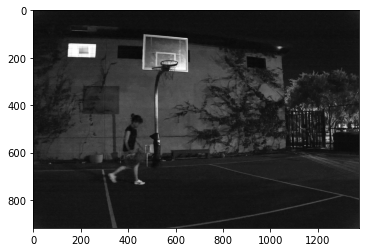

In [35]:
M_scaled_reshape = M_scaled[:,19].reshape((1374,918))
plt.imshow(M_scaled_reshape.T,cmap='gray')
plt.show()

### Visualization of L[:, 20] and S[:,20]

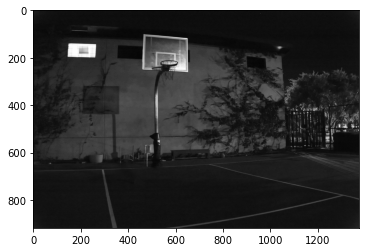

In [36]:
L_scaled = (L_k - np.min(L_k)) / (np.max(L_k) - np.min(L_k))
L_scaled_reshape = L_k[:,19].reshape((1374,918))
plt.imshow(L_scaled_reshape.T,cmap='gray')
plt.show()

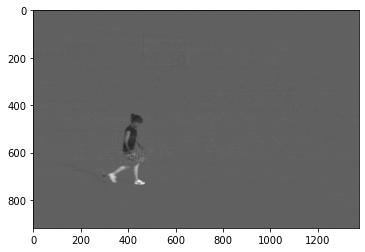

In [37]:
S_scaled = (S_k - np.min(S_k)) / (np.max(S_k) - np.min(S_k))
S_scaled_reshape = S_k[:,19].reshape((1374,918))
plt.imshow(S_scaled_reshape.T,cmap='gray')
plt.show()

## (e) making a background and moving object video

In [28]:
fps = 60

In [29]:
L_reshape_scaled_total = L_scaled.reshape((1374,918,112))
for i in range(112):
    cv2.imwrite(f'./img/L{i}.png',np.uint8(L_reshape_scaled_total[:,:,i].T * 255))
    
S_reshape_scaled_total = S_scaled.reshape((1374,918,112))
for i in range(112):
    cv2.imwrite(f'./img/S{i}.png',np.uint8(S_reshape_scaled_total[:,:,i].T * 255))

In [30]:
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
bg = cv2.VideoWriter('background.avi', fourcc, fps, (1374, 918))
for i in range(112):
    image = cv2.imread(f'./img/L{i}.png')
    bg.write(image)
bg.release()
cv2.destroyAllWindows()

In [31]:
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
people = cv2.VideoWriter('people.avi', fourcc, fps, (1374, 918))
for i in range(112):
    image = cv2.imread(f'./img/S{i}.png')
    people.write(image)
people.release()
cv2.destroyAllWindows()